In [6]:
#################################################################
## We need Altair, Pandas, and JSON packages.
## For computing TF-IDF, we need scikit-learn, however, we only
## import that inside showTopWords(). You will need to install
## scikit-learn if you'd like to run the second visualization.
#################################################################
import altair as alt
import pandas as pd
import json

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [1]:
def loadData():
    """Load reviews from ios_reviews.json and android_reviews.json
    
    Args:
        contents (iterable): an iterable of 'str' containing the review contents

    Return:
        dict (of DataFrame): key is platform name, value is the corresponding
            data frame containing 'name', 'rating', and 'content'.
    """
    ios_reviews = json.load(open('ios_reviews.json', 'r'))
    android_reviews = json.load(open('android_reviews.json', 'r'))

    ## We ignore the 
    dfIOS = pd.DataFrame(((app, review['rating'], review['review'])
                          for app,reviews in ios_reviews.items() 
                          for review in reviews), columns=['name', 'rating', 'content'])
    dfAndroid = pd.DataFrame(((app, review['rating'], review['review'])
                              for app,reviews in android_reviews.items()
                              for review in reviews), columns=['name', 'rating', 'content'])
    return {'ios': dfIOS, 'android': dfAndroid}

def showRatingDistribution(data, name=''):
    """Create an interaactive visualization showing the distribution of ratings
    
    Args:
        data (DataFrame): the input data frame that must at least consists
            two columns 'name' and 'rating' for app names and ratings.
        name (str): the name of the platform (optional) to be displayed.

    Return:
        Chart: an Altair chart object that corresponds to the visualization
    """
    ## The color expression for highlighting the bar under mouse
    color_expression    = "highlight._vgsid_==datum._vgsid_"
    color_condition     = alt.ConditionalPredicateValueDef(color_expression, "SteelBlue")
    
    ## There are two types of selection in our chart:
    ## (1) A selection for highlighting a bar when the mouse is hovering over
    highlight_selection = alt.selection_single(name="highlight", empty="all", on="mouseover")
    
    ## (2) A selection for updating the rating distribution when the mouse is clicked
    ## Note the encodings=['y'] parameter is needed to specify that once a selection
    ## is triggered, it will propagate the encoding channel 'y' as a condition for
    ## any subsequent filter done on this selection. In short, it means use the data
    ## field associated with the 'y' axis as a potential filter condition.
    rating_selection    = alt.selection_single(name="rating", empty="all", encodings=['y'])
    
    ## We need to compute the max count to scale our distribution appropriately
    maxCount            = int(data['rating'].value_counts().max())

    ## Our visualization consists of two bar charts placed side by side. The first one
    ## sorts the apps by their average ratings as below. Note the compound selection
    ## that is constructed by adding the two selections together.
    barMean = alt.Chart() \
        .mark_bar(stroke="Black") \
        .encode(
            alt.X("mean(rating):Q", axis=alt.Axis(title="Rating")),
            alt.Y('name:O', axis=alt.Axis(title="{} App Name".format(name)), 
                  sort=alt.EncodingSortField(field="rating", op="mean", order='descending')),
            alt.ColorValue("LightGrey", condition=color_condition),
        ).properties(
            selection = highlight_selection+rating_selection,
        )

    ## The second one uses the selected app specified by the rating_selection
    ## to filter the data, and build a histogram based on the ratings. Note
    ## the use of rating_selection.ref() as a condition for transform_filter().
    ## The scale was explicitly constructed for the X axis to fill out the 
    ## the potential empty values, e.g. no one gave an app a score of 3, but
    ## we still want to show 1, 2, 3, 4, and 5 in the axis (but not in with .5).
    barRating = alt.Chart() \
        .mark_bar(stroke="Black") \
        .encode(
            alt.X("rating:O", axis=alt.Axis(title="Rating"),
                  scale=alt.Scale(type='band', domain=list(range(1,6))),
                 ),
            alt.Y("count()", axis=alt.Axis(title="Number of Ratings"),
                  scale=alt.Scale(domain=(0,maxCount)),
                 ),
            alt.ColorValue("LightGrey"),
        ).properties(
            selection = highlight_selection,
        ).transform_filter(
            rating_selection.ref()
        )
        
    ## We just need to concatenate the plots horizontally, and return the result.
    return alt.hconcat(barMean, barRating,
        data=data,
        title="{} App Ratings".format(name)
    )

def showTopWords(contents):
    """Create a plot showing important words in the review contents
    
    Args:
        contents (iterable): an iterable of 'str' containing the review contents

    Return:
        Chart: an Altair chart object that corresponds to the visualization
    """
    ## We import sklearn inside the function to avoid the global requirement
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    def removeStopWords(contents):
        """Go through each message and remove unimportant (stop) words"""
        import re
        separator = re.compile('\W+')
        ## We load the list of stopwords from stopwords.txt
        stopwords = set(map(lambda x: x.strip(), open('stopwords.txt', 'r').readlines()))
        ## ... and add the popular word "app" to add
        stopwords.add('app')
        words = []
        for line in contents:
            words.append(' '.join(w for w in separator.split(line.lower())
                                  if w and w not in stopwords))
        return words

    def plotWords(dfWords):
        """Create the plot based on the data frame of words and the number of
        reviews they appear in"""
        
        ## This is similar to the bar chart above, except that we dont' have
        ## to deal with selections
        color_expression    = "highlight._vgsid_==datum._vgsid_"
        color_condition     = alt.ConditionalPredicateValueDef(color_expression, "SteelBlue")
        highlight_selection = alt.selection_single(name="highlight", empty="all", on="mouseover")
        maxCount            = int(dfWords['freq'].max())

        return alt.Chart(dfWords) \
            .mark_bar(stroke="Black") \
            .encode(
                alt.X("freq", axis=alt.Axis(title="Count", tickCount=min(maxCount, 6))),
                alt.Y('word:O', axis=alt.Axis(title="Keyword"),
                      sort=alt.EncodingSortField(field="freq", op="max", order='descending')),
                alt.ColorValue("LightGrey", condition=color_condition),
            ).properties(
                selection = highlight_selection
            )

    ## Our pipeline is to remove the stop words from each review, and then compute
    ## TF-IDF for each remaining word.
    words = removeStopWords(contents.dropna())
    tfidf = TfidfVectorizer()
    model = tfidf.fit_transform(words)
    features = tfidf.get_feature_names()
    topWords = {}
    
    ## We only keep the words that has the normalized weight of some threshold,
    ## e.g. 0.2 or larger.
    for row in model:
        words = list(map(lambda x: features[x[0]], 
                         sorted(filter(lambda x: x[1]>0.2, 
                                       enumerate(row.toarray().tolist()[0])), 
                                key=lambda x: -x[1])))
        for w in words:
            topWords[w] = topWords.get(w, 0)+1
            
    ## ... and compute its frequency, i.e. how many reviews it appeared in.
    ## Then creating a data frame of words with at least 2 appearances.
    dfWords = pd.DataFrame(list(filter(lambda x: x[1]>2, topWords.items())), 
                           columns=['word', 'freq'])
    
    ## Before feeding the top ten to our plot function
    return plotWords(dfWords[:10])


In [12]:
data = loadData()
dfIOS = data['ios']
dfAndroid = data['android']
len(dfIOS) + len(dfAndroid)

506

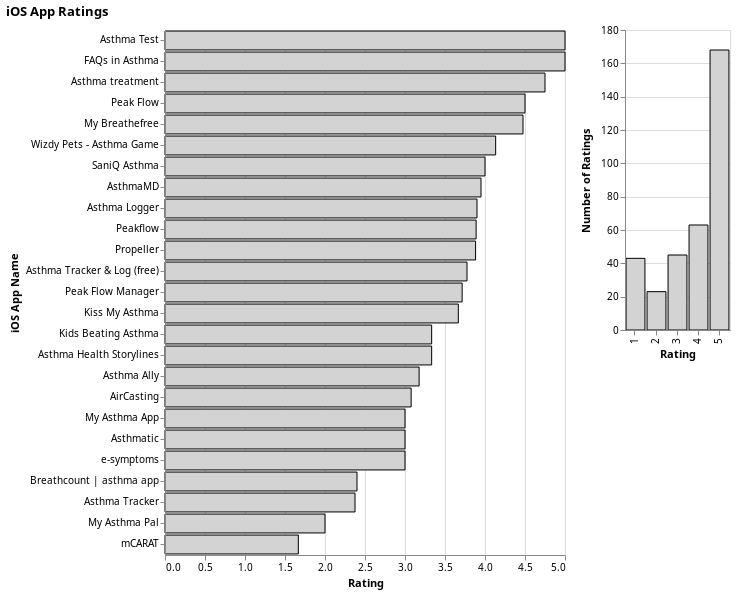

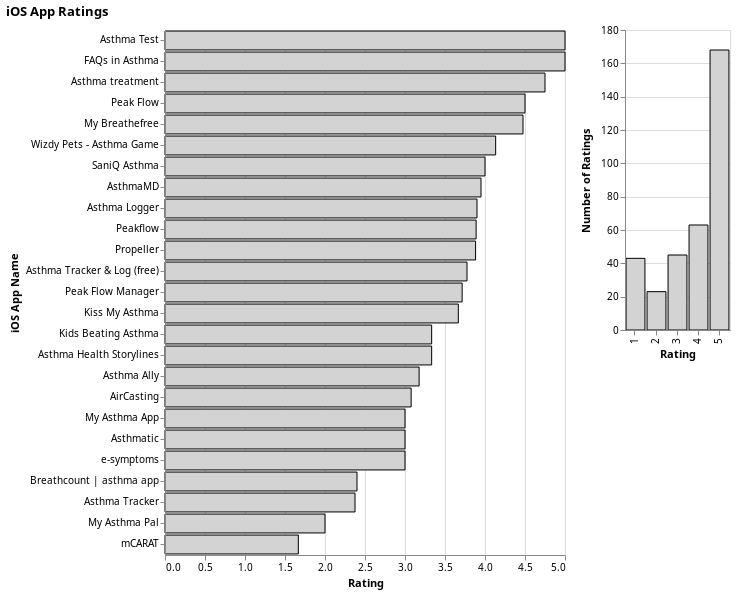

In [13]:
showRatingDistribution(dfAndroid, 'iOS')

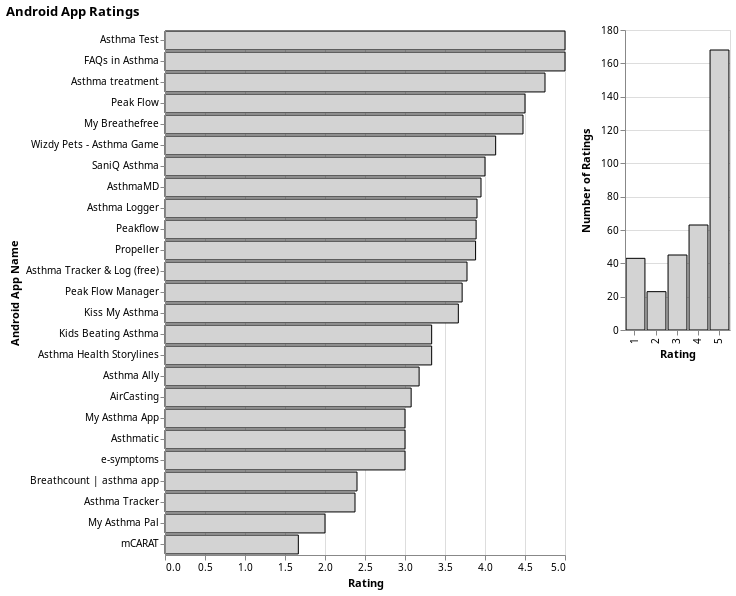

In [14]:
showRatingDistribution(dfAndroid, 'Android')

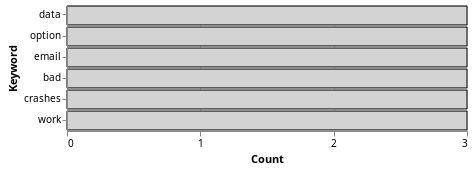

In [16]:
showTopWords(dfAndroid[dfAndroid.rating==1]['content'])

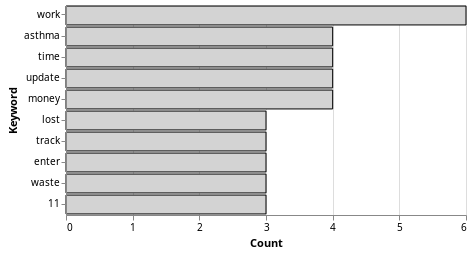

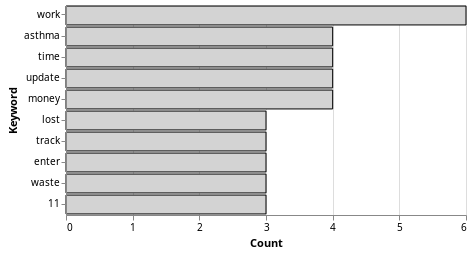

In [17]:
showTopWords(dfIOS[dfIOS.rating==1]['content'])

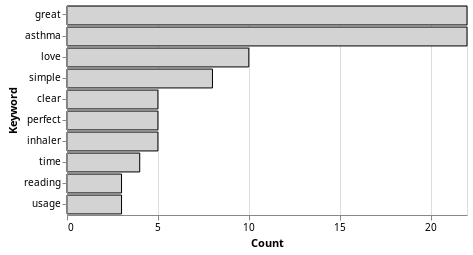

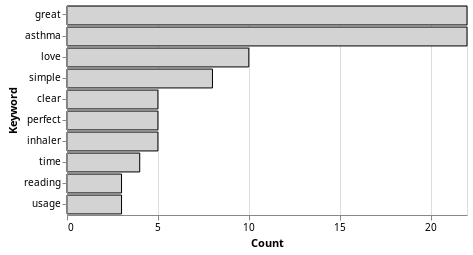

In [18]:
showTopWords(dfAndroid[dfAndroid.rating==5]['content'])

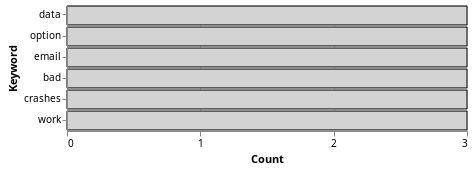

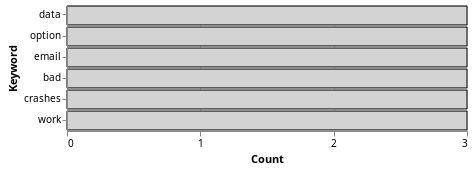

In [19]:
showTopWords(dfAndroid[dfAndroid.rating==1]['content'])